In [1]:
# Enable inline plots and Qt windows
%matplotlib inline
%gui qt

import glob, os, time
import numpy as np
import torch
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Normalize

print("🚀 Full-res, no-downsample depth → point-cloud…")

🚀 Full-res, no-downsample depth → point-cloud…


In [2]:
# 1) Load image
cands = glob.glob("Mickeymouse*.jpg")
assert cands, "No file matching Mickeymouse*.jpg in cwd"
img_path = cands[0]
print("1) Loading image:", img_path)
img = Image.open(img_path).convert("RGB")
w, h = img.size


1) Loading image: Mickeymouse.jpg


In [3]:

# 2) Load DPT_Large
print("2) Loading MiDaS DPT_Large…")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t0 = time.time()
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large").to(device).eval()
print(f"   → model ready in {time.time()-t0:.1f}s on {device}")


2) Loading MiDaS DPT_Large…


Using cache found in C:\Users\karsh/.cache\torch\hub\intel-isl_MiDaS_master


   → model ready in 6.1s on cpu


In [4]:
# 3) Patchwise inference (no downsample)
print("3) Patchwise inference (no downsample)…")

from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image

patch_size = 384
overlap    = 64
stride     = patch_size - overlap

transform  = Compose([
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225]),
])

# Accumulators for stitching
depth_acc  = np.zeros((h, w), dtype=np.float32)
weight_acc = np.zeros((h, w), dtype=np.float32)

with torch.no_grad():
    for y0 in range(0, h, stride):
        for x0 in range(0, w, stride):
            y1 = min(y0 + patch_size, h)
            x1 = min(x0 + patch_size, w)

            # Crop and pad to patch_size×patch_size
            crop = img.crop((x0, y0, x1, y1))
            if crop.size != (patch_size, patch_size):
                pad = Image.new("RGB", (patch_size, patch_size))
                pad.paste(crop, (0, 0))
                crop = pad

            # Run through MiDaS
            inp = transform(crop).unsqueeze(0).to(device)
            pred = midas(inp)
            dp = torch.nn.functional.interpolate(
                pred.unsqueeze(1),
                size=(patch_size, patch_size),
                mode="bicubic",
                align_corners=True
            ).squeeze().cpu().numpy()

            # Un-pad
            dp = dp[:(y1 - y0), :(x1 - x0)]

            # Accumulate & count overlaps
            depth_acc[y0:y1, x0:x1]  += dp
            weight_acc[y0:y1, x0:x1] += 1.0

# Final full-res depth map
depth = depth_acc / weight_acc
print(f"   → assembled full-res depth: {depth.shape}")


3) Patchwise inference (no downsample)…


C:\Users\karsh\anaconda3\envs\open3ddenv\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


   → assembled full-res depth: (778, 640)


In [5]:
# 4) Save 16-bit depth
dmin, dmax = depth.min(), depth.max()
depth16 = ((depth - dmin)/(dmax - dmin)*65535).astype(np.uint16)
Image.fromarray(depth16).save("depth_fullres_16bit.png")
print("4) Saved depth_fullres_16bit.png")

4) Saved depth_fullres_16bit.png


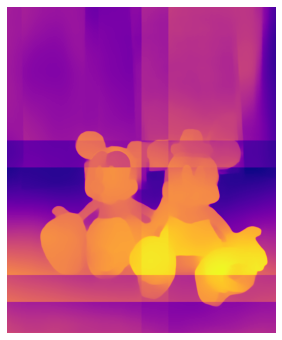

In [6]:

# 4a) Preview 8-bit
depth8 = (depth16>>8).astype(np.uint8)
plt.figure(figsize=(8,6))
plt.imshow(depth8, cmap="plasma")
plt.axis("off"); plt.show()

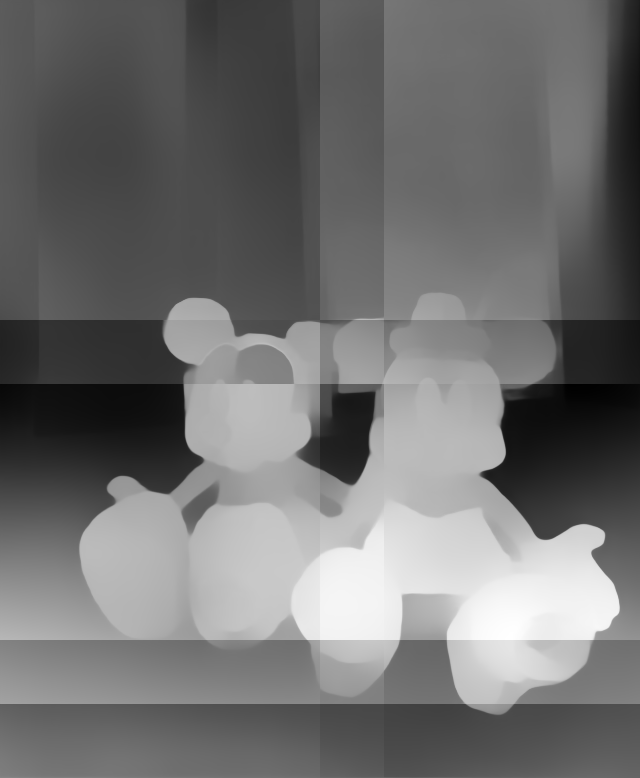

In [12]:
from IPython.display import Image, display

# replace with your actual filename if different
depth_file = "depth_fullres_16bit.png"

# make sure the file exists
import os
assert os.path.isfile(depth_file), f"{depth_file!r} not found"

display(Image(filename=depth_file))


In [7]:
# 5) Back-project to full-res point cloud
print("5) Back-projecting to full-res point-cloud…")
f, cx, cy = max(w,h), w/2, h/2
uu, vv    = np.meshgrid(np.arange(w), np.arange(h))
X = (uu-cx)*depth/f
Y = (vv-cy)*depth/f
Z = depth
pts   = np.stack([X,Y,Z], axis=-1).reshape(-1,3)
cols  = np.asarray(img).reshape(-1,3)/255.0
print("   → total points:", pts.shape[0])

5) Back-projecting to full-res point-cloud…
   → total points: 497920


In [8]:

# 6) Build point cloud (no downsampling, no filtering)
print("6) Building point cloud (raw)…")
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
pcd.colors = o3d.utility.Vector3dVector(cols)

ply_out = "cloud_fullres_raw.ply"
o3d.io.write_point_cloud(ply_out, pcd)
print("   → Saved point cloud to", ply_out)


6) Building point cloud (raw)…
   → Saved point cloud to cloud_fullres_raw.ply


In [14]:
# 7) Visualize
print("7) Launching Open3D viewer…")
o3d.visualization.draw_geometries([pcd])
print("✅ Done, no downsampling applied!")

7) Launching Open3D viewer…
✅ Done, no downsampling applied!
